# Transformers

https://arxiv.org/pdf/1706.03762.pdf

Transformers are an alternative to RNN architectures. The authors state that transformers have higher performance and can be trained faster, since they can be easily parallelized.

Here we will use the Transformer architecture to classify dates to the rule they were generated from. While this is not a sequence to sequence task, we will still use the transformer to embed a sequence of text.

## A primer on the transformer encoder architecture

There are a few parts of the transformer to pay attention to. The most important parts are multiheaded attention and self attention. 

### Multiheaded attention
![Multiheaded attention](img/multiheaded.png)
See Figure 2 and Section 3.2.2 from the paper, for your reference the figure is provided here. 

This mechanism is noticably more unique than Luong and Bahdanau's attention mechanisms for 2 reasons.
1. The query, key, and value are projected into different vector spaces.
2. The standard attention mechanism is duplicated multiple times, hence "multiheaded attention".

**The following is speculation**
1. Having different query, key, and value projections allow the transformer to be more flexible in how and what it learns to focus on. As an example, say we are embedding the sequence "The brave soul.". If we were to apply self attention to the word embeddings, our first query would be "The" and the keys would be all of the other words. If we did not project the query and key into different spaces, the attention values would heavily weight "The" instead of "brave" and "soul" since "The" will have a large dot product with itself and the other words will likely have orthogonal components that will make their dot product with "The" smaller. My hypothesis is that without self attention the attention mechanism would not be helpful in providing context specific meanings.
2. One weakness of Luong and Badanhau attention, which may actually be a strength in NMT, is that each query can only focus on one-ish key. This is due to the softmax activation. Here it is possible to focus on multiple keys since we are taking multiple softmaxs.

### Self attention
This is the logic in the transformer that allows it to be a replacement for an RNN. Instead of applying the attention mechanism between an encoder and decoder, you allow the encoder to apply attention to itself. This allows for each element in a sequence to be "aware" of the context it lives in. For text, this means that each word will have an embedding that reflects its surrounding words. To acheive this all you need to do is feed the same word embeddings as the query, key, and value in the multiheaded attention mechanism.

**Implementation note**

For modeling text the self attention computation can be very expensive, both in time and memory, since the matrix multiply results in a (batch_size, num_attn_heads, timesteps, timesteps) matrix. 

# 1. Import, load, and define dataset

In [1]:
import os
# change this to run on a specific GPU on your machine, indexing starts at 0
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import math
import random
import string
from pathlib import Path
from typing import Callable, List, Tuple

import ipywidgets as widgets
from IPython.display import display, HTML

from fastai.basic_data import DataBunch, DatasetType
from fastai.metrics import accuracy
from fastai.train import Learner
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

%matplotlib inline
plt.rcParams["figure.figsize"] = [6, 8]

In [3]:
_DATA_PATH = Path('../data')
_RAW_PATH = _DATA_PATH / 'raw'

In [4]:
def load_dataframes(raw_path):
    df_names = ['train', 'valid', 'test']
    dfs = [pd.read_csv(raw_path/f'{df_name}.csv') for df_name in df_names]
    return dfs


def create_vocab():
    tokens = ['<pad>', '<unk>', '<sos>', '<eos>'] + list(string.printable)
    tok_to_int = {c: i for i, c in enumerate(tokens)}
    int_to_tok = [c for c, i in tok_to_int.items()]
    assert tok_to_int['<pad>'] == 0
    assert tok_to_int['<unk>'] == 1
    assert tok_to_int['<sos>'] == 2
    return tok_to_int, int_to_tok

def build_text_mapper(tok_to_int: dict) -> Callable:
    def mapper(text: str):
        return [tok_to_int['<sos>']] + [tok_to_int.get(c, 1) for c in text] + [tok_to_int['<eos>']]
    return mapper

### Load data and create character -> int mapping

In [6]:
train_df, valid_df, test_df = load_dataframes(_RAW_PATH)
tok_to_int, int_to_tok = create_vocab()

### Define a classification dataset
Input: 

    encoder input: Noisy date text, i.e. `Saturday December 23, 1834`
    
output: 

    The integer corresponding to the date format which generated the encoder input.
    
The following dataset code is specific to pytorch and may seem a bit convoluted. It just maps an integer index to a single training sample, as described above.

In [7]:
# the model will see sequences of length 32.
# any date shorter than 32 characters will be padded.
_MAXLEN = 32

class DateDataset(utils.data.Dataset):
    """
    Maps an index to a tuple of (inputs, outputs).
    
    Example
    -------
    ds = DateDataset(df, text_mapper)
    ds[0]
    """
    def __init__(self, df: pd.DataFrame, text_mapper: Callable) -> None:
        self.df = df
        self.x_col = 'input'
        self.y_col = 'format'
        self.maxlen = _MAXLEN
        self.pad_val = 0
        self.text_mapper = text_mapper
        self.c = len(self.df[self.y_col].unique())  # num unique classes
        
        self._prepare_data()
    
    def _prepare_data(self):
        self.df['encode_text'] = self.df[self.x_col].apply(self.get_tokens, args=('pre',))
    
    def __getitem__(self, idx: int):
        sample = self.df.iloc[idx]
        encode_text = sample.encode_text
        format_label = torch.LongTensor([sample[self.y_col]])
        return {
            'encode_text': encode_text,
            'output': format_label
        }
    
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def get_tokens(self, text: str, mode: str) -> torch.LongTensor:
        if random.random() < 0.5:
            text = text.lower()
        tokens = self.text_mapper(text)
        tokens = self._pad_sequence(tokens, mode)
        return torch.LongTensor(tokens)
    
    def _pad_sequence(self, seq: List, mode: str) -> List:
        diff = self.maxlen - len(seq)
        if diff < 0:
            raise ValueError('Can not pad a sequence longer than maxlen')
        if mode == 'pre':
            return [self.pad_val] * diff + seq
        elif mode == 'post':
            return seq + [self.pad_val] * diff
        else:
            raise ValueError('mode must be pre or post')


def collate_batch(batch: List):
    """Stack each sample together to make a batch."""
    # text will have shape (B, T)
    encode_text = torch.stack([sample['encode_text'] for sample in batch])
    # y, needs to be flat to calculate the loss
    # y shape = (B*T, )
    y = torch.cat([sample['output'] for sample in batch])
    return encode_text, y

In [19]:
text_mapper = build_text_mapper(tok_to_int)

train_ds = DateDataset(train_df, text_mapper)
valid_ds = DateDataset(valid_df, text_mapper)
test_ds = DateDataset(test_df, text_mapper)

device_str = 'cuda:0' if torch.cuda.is_available() else 'cpu'
data = DataBunch.create(train_ds, valid_ds, test_ds, bs=256, collate_fn=collate_batch, device=torch.device(device_str))

In [23]:
# visualize one batch
xb, yb = data.one_batch()
print(f'Batch size: {xb.size(0)}')
print('X_batch')
print(xb)
print('Y_batch')
print(yb)
print('Num classes:', data.c)

Batch size: 256
X_batch
tensor([[ 0,  0,  0,  ..., 11, 13,  3],
        [ 0,  0,  0,  ...,  4, 11,  3],
        [ 0,  0,  0,  ...,  6, 12,  3],
        ...,
        [ 0,  0,  0,  ...,  5,  7,  3],
        [ 0,  0,  0,  ..., 11,  6,  3],
        [ 0,  0,  0,  ...,  6,  8,  3]])
Y_batch
tensor([ 2,  5, 12,  3,  6,  6,  5,  4,  8, 12,  8,  1,  5, 11,  4,  7,  9, 10,
        10,  5, 11, 12, 10,  8,  2,  1,  6,  3,  4,  3,  1,  6,  6,  1,  0, 10,
         0, 10,  5,  5,  7, 12,  9, 12,  3, 10,  9,  0,  4,  6, 11,  1,  7, 10,
         0, 12,  8,  1, 12, 10,  0,  9, 11,  8,  0,  1,  8,  0, 12,  6,  4, 10,
         7,  1,  1,  1,  8,  7,  3,  6,  7,  3,  3, 11,  2,  3,  4,  2,  7,  2,
         1,  8,  2,  2, 10,  8,  7,  1,  9,  7,  3,  7,  4, 11,  0,  7,  9, 10,
         4,  5,  4,  7,  0,  1,  1,  9,  5,  7,  9,  2,  6,  0,  2,  8,  9,  5,
         8,  1,  1,  3,  3,  2,  3, 10,  8,  4,  2,  8, 12,  9,  6, 12,  1,  8,
         9,  6,  5,  5, 11, 10,  0,  7,  0,  9,  0, 11,  2,  0,  9,  7,  3

# 2. Transformer Encoder Architecture

We will use pytorch for this implementation. It is worth noting that pytorch has an implementation of the transformer architecture, both encoder and decoder.

#### Potitional Embedding

The positional embedding is critical for the transformer to be able to "know" where is the sequence it is looking at.

Vaswani et al. used a sinusoid function to generate these embeddings.

In [69]:
# set model config
# this is a pretty small network, any bigger and the model can easy solve this problem.
# I am purposefully trying to make it difficult for the vanilla model to "solve" this problem.

_HIDDEN_SIZE = 64
_NUM_LAYERS = 2
_NUM_HEADS = 4

In [81]:
class PositionalEmbedding(nn.Module):
    def __init__(self, maxlen: int, hidden_size: int) -> None:
        super().__init__()
        self.embedding_layer = nn.Embedding(
            maxlen,
            hidden_size
        )
        self._init_position_weights()

    def _init_position_weights(self) -> None:
        """
        Set and freeze the sinusoid weights.
        Attention is all you need - Section 3.5
        """
        W = torch.zeros_like(self.embedding_layer.weight)
        timesteps, dims = W.size()
        for pos in range(timesteps):
            for dim in range(dims):
                val = torch.tensor( pos / 10000 ** (dim / dims) )
                if dim % 2 == 0:
                    W[pos, dim] = torch.sin(val)
                else:
                    W[pos, dim] = torch.cos(val)
        self.embedding_layer.weight = torch.nn.Parameter(W, requires_grad=False)

    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        return self.embedding_layer(X)

    @property
    def weight(self):
        return self.embedding_layer.weight

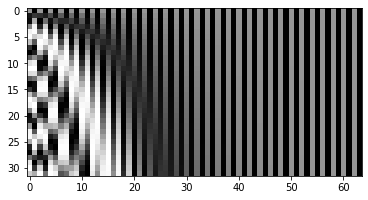

In [82]:
pos_emb = PositionalEmbedding(_MAXLEN, _HIDDEN_SIZE)
plt.imshow(
    pos_emb(torch.arange(0, 32)).cpu().numpy(),
    cmap='Greys'
)

#### The transformer encoder

In [83]:
class TransformerEmbedding(nn.Module):
    """Token and positional embedding for the Transformer."""
    def __init__(self, vocab_size: int, hidden_size: int, maxlen: int) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.maxlen = maxlen
        self.word_embedding = nn.Embedding(
            self.vocab_size,
            self.hidden_size,
            padding_idx=0
        )
        self.pos_embedding = PositionalEmbedding(
            maxlen,
            hidden_size
        )

    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        B, T = X.size()
        w_emb = self.word_embedding(X)
        p_emb = self.pos_embedding(self.get_position_ints(B, T))
        # scale by sqrt(hidden size), Vaswani et al. Section 3.4
        emb = math.sqrt(self.hidden_size) * w_emb + p_emb
        return emb
    
    def get_mask(self, X: torch.LongTensor) -> torch.ByteTensor:
        """Get the mask for the transformer."""
        return (X == 0)  # (B, T)
    
    def get_position_ints(self, batch_size: int, length: int) -> torch.LongTensor:        
        X = torch.zeros(batch_size, length, dtype=torch.int64)
        X[:] = torch.arange(length)
        return X.to(self.device)

    @property
    def device(self):
        return list(self.parameters())[0].device


class DateEncoder(nn.Module):
    def __init__(self, tok_to_int) -> None:
        super().__init__()
        self.maxlen = _MAXLEN
        self.vocab_size = len(tok_to_int)
        self.hidden_size = _HIDDEN_SIZE
        self.num_layers = _NUM_LAYERS
        self.num_heads = _NUM_HEADS

        self.embedding_layer = TransformerEmbedding(
            self.vocab_size,
            self.hidden_size,
            self.maxlen
        )

        transformer_layer = nn.TransformerEncoderLayer(
            self.hidden_size,
            self.num_heads,
            dim_feedforward=self.hidden_size,
        )
        self.transformer = nn.TransformerEncoder(
            transformer_layer,
            self.num_layers,
            norm=nn.LayerNorm(self.hidden_size)
        )
        
    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        emb = self.embedding_layer(X)  # (B, T, e)
        emb_t = torch.transpose(emb, 0, 1)  # (T, B, e)
        mask = self.embedding_layer.get_mask(X)  # (B, T)
        emb_t = self.transformer(emb_t, src_key_padding_mask=mask)  # (T, B, e)
        return emb_t


class DateClassifier(nn.Module):
    def __init__(self, tok_to_int: dict, output_dim: int) -> None:
        super().__init__()
        self.output_dim = output_dim
        self.encoder = DateEncoder(tok_to_int)
        self.densor = nn.Sequential(
            nn.Linear(self.encoder.hidden_size, self.encoder.hidden_size),
            nn.ReLU(),
            nn.Linear(self.encoder.hidden_size, output_dim)
        )
    
    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        emb = self.encoder(X)  # (T, B, e)
        last_emb = emb[-1]  # (B, e)
        logit = self.densor(last_emb)
        log_prob = F.log_softmax(logit, dim=-1)
        return log_prob

#### Hooks let us inspect the inputs/outputs of intermediate layers

For more examples and explanation.
https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/

In [84]:
def decode_tensor(x: torch.LongTensor, int_to_tok: dict, strip_pad: bool = False):
    """Decode the model output, int -> char.
    Optionally remove all padding characters.
    """
    if strip_pad:
        return [int_to_tok[i] for i in x if i!=0]
    return [int_to_tok[i] for i in x]


def find_attn_modules(model: nn.Module, attn_modules: list, depth = 0):
    """Get all the attention modules in a model."""
    for i, module in enumerate(model.children()):
        if isinstance(module, nn.MultiheadAttention):
            attn_modules += [module]
        else:
            find_attn_modules(module, attn_modules, depth + 1)


class AttnModelHooks:
    def __init__(self, model: nn.Module) -> None:
        self.data = dict()  # store the inputs/outputs of intermediate layers here
        self.embedding_module = model.encoder.embedding_layer
        self.output_module = model.densor
        self.attn_modules = []
        find_attn_modules(model, self.attn_modules, 0)
        
    def register(self):
        self.embedding_module.register_forward_hook(self.text_hook)
        self.output_module.register_forward_hook(self.output_hook)
        for layer in self.attn_modules:
            layer.register_forward_hook(self.attn_hook)

    def text_hook(self, module: nn.Module, inputs: tuple, outputs: tuple):
        assert isinstance(module, TransformerEmbedding)
        token_ids = inputs[0]
        decoded = [decode_tensor(ids, int_to_tok, strip_pad=True) for ids in token_ids]
        self.data['text'] = decoded

    def attn_hook(self, module: nn.Module, inputs: tuple, outputs: tuple):
        assert isinstance(module, nn.MultiheadAttention)
        # these are attn values averaged over num_heads
        # unfortunately its not straight forward to get the unaaveraged values
        attn_weights = outputs[-1]  # (B, Tq, Tv), https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py#L3430
        self.data[module] = attn_weights

    def output_hook(self, module: nn.Module, inputs: tuple, outputs: tuple):
        assert isinstance(module, nn.Sequential)
        self.data['logit'] = outputs

    def get_attn_data(self, idx: int) -> torch.FloatTensor:
        attn = []
        for layer in self.attn_modules:
            attn.append(self.data.get(layer)[idx])
        return torch.stack(attn, dim=0)

    def get_text_data(self, idx: int) -> List[str]:
        return self.data['text'][idx]
    
    def get_output_data(self, idx: int) -> torch.FloatTensor:
        return self.data['logit'][idx]

    def plot_attn(self, idx: int):
        attn_weights = self.get_attn_data(idx)
        text = self.get_text_data(idx)
        N = len(text)
        ticks = np.arange(N)
        for dim in range(attn_weights.size(0)):
            attn_vals = attn_weights[dim].detach().cpu().numpy()
            attn_vals = attn_vals[-N:, -N:]
            plt.imshow(attn_vals, cmap='gray', vmin=0., vmax=1.)
            plt.yticks(ticks, text)
            plt.xticks(ticks, text, rotation=45)
            plt.show()

### Train the classifier

In [85]:
model = DateClassifier(tok_to_int, data.c)
hooks = AttnModelHooks(model)
learner = Learner(data, model, loss_func=nn.NLLLoss(), opt_func=optim.Adam, metrics=[accuracy])
hooks.register()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


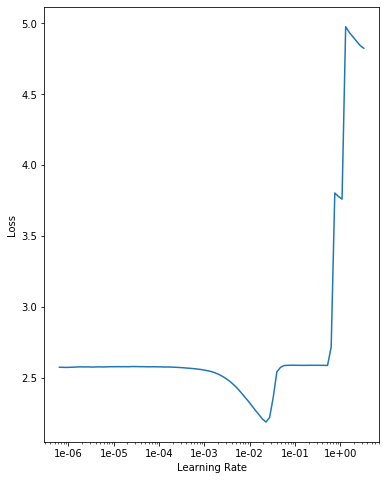

In [86]:
learner.lr_find()
learner.recorder.plot()

In [87]:
learner.fit_one_cycle(2, max_lr=1e-2)
learner.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.671052,0.643782,0.601600,01:21
1,0.611416,0.595853,0.649500,01:21


epoch,train_loss,valid_loss,accuracy,time
0,0.551282,0.523535,0.688100,01:21
1,0.402857,0.375477,0.759700,01:21
2,0.389530,0.369835,0.773400,01:21
3,0.318420,0.272692,0.823300,01:20
4,0.254584,0.230931,0.839000,01:22


In [90]:
def get_one_sample(learner: Learner, ds_type: DatasetType, idx: int, int_to_tok: dict) -> dict:
    ds = learner.data.dl(ds_type).dataset
    sample = ds[idx]
    sample['text'] = decode_tensor(sample['encode_text'], int_to_tok, strip_pad=True)
    return sample

def make_prediction_on_sample(learner: Learner, hooks, ds_type: DatasetType, idx: int, int_to_tok: dict):
    sample = get_one_sample(learner, ds_type, idx, int_to_tok)
    xb, yb = learner.data.collate_fn([sample])
    xb = xb.to(learner.data.device)
    yb = yb.to(learner.data.device)
    
    with torch.no_grad():
        log_prob = learner.model(xb)
        pred_label = log_prob.argmax(-1).item()
    hooks.plot_attn(0)  # since the batch size is 1, always plot the 0 index
    print(f'Ground truth: {yb.item()}')
    print(f'Prediction: {pred_label}')

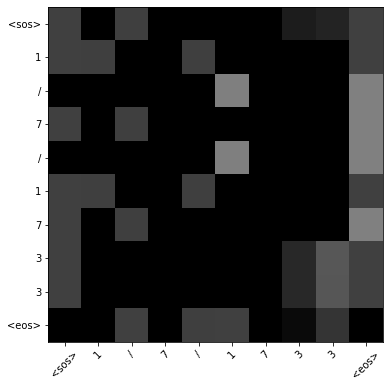

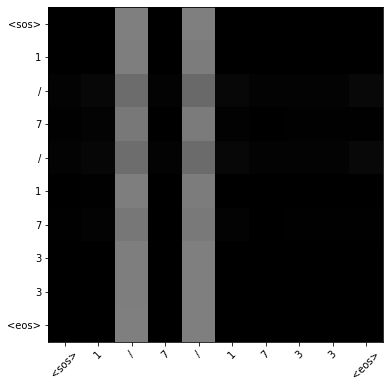

Ground truth: 4
Prediction: 5


In [91]:
make_prediction_on_sample(learner, hooks, DatasetType.Valid, 3, int_to_tok)